In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!cp "/content/drive/My Drive/Histopathology data/lung cancer.zip" "lung cancer.zip"
!unzip -q 'lung cancer.zip'

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('lung cancer/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, test_files, train_classes, test_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['NORM' 'TUM']


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 10 # 
batch_size_test = 10#

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('lung cancer/', train_files, train_classes, 
                         transforms=image_transform)
test_dataset = Hist('lung cancer/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: TUM


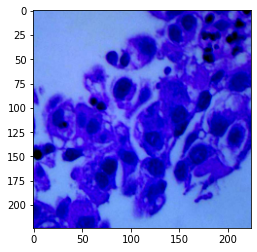

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class Inceptionblock(nn.Module):
    def __init__(self, input_channels, n1x1, n3x3_reduce, n3x3, n5x5_reduce, n5x5, pool):
        super().__init__()

        # convolution: 1x1 
        self.b1 = nn.Sequential(
            nn.Conv2d(input_channels, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(inplace=True)
        )

        # convolution: 1x1  -> convolution: 3x3 
        self.b2 = nn.Sequential(
            nn.Conv2d(input_channels, n3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(n3x3_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n3x3_reduce, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(inplace=True)
        )

        # convolution: 1x1 -> convolution: 5x5
        # Two 3x3 stacked convolution filters used
        self.b3 = nn.Sequential(
            nn.Conv2d(input_channels, n5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(n5x5_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5_reduce, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5, n5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True)
        )

        # pooling: 3x3 -> convolution: 1x1
        
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(input_channels, pool, kernel_size=1),
            nn.BatchNorm2d(pool),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)], dim=1)


class GoogleNet(nn.Module):

    def __init__(self, num_class=2):
        super().__init__()
        self.prelayer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
        )

        
        self.a3 = Inceptionblock(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inceptionblock(256, 128, 128, 192, 32, 96, 64)

        # The Inception network consists of inception modules stacked upon each other, with occasional max-pooling layers
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inceptionblock(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inceptionblock(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inceptionblock(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inceptionblock(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inceptionblock(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inceptionblock(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inceptionblock(832, 384, 192, 384, 48, 128, 128)

        #input feature size: 8*8*1024
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d(p=0.4)
        self.linear = nn.Linear(1024, num_class)

    def forward(self, x):
        x = self.prelayer(x)
        x = self.maxpool(x)
        x = self.a3(x)
        x = self.b3(x)

        x = self.maxpool(x)

        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)

        x = self.maxpool(x)

        x = self.a5(x)
        x = self.b5(x)

        
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)

        return x

In [ ]:
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GoogleNet().to(device)
learning_rate = 0.0005
weight_decay = 0.001
for param in model.parameters():
    param.requires_grad = True
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(parameters, lr=learning_rate, weight_decay=weight_decay)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        
        data, target = data.to(device), target.to(device)  
        
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    
##define test function
def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
        
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import os.path
from os import path

num_epoch = 30
train_loss=[]
test_loss=[]
accuracy_test=[]
acc=0
for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=test(model, device, test_loader)
    if acc<acct:
      if path.exists("GoogleNetLungmodel.pth"):
        os.remove("GoogleNetLungmodel.pth")

      torch.save(model.state_dict(), 'GoogleNetLungmodel.pth')
      acc=acct
    train_loss.append(tl)
    test_loss.append(stl)
    accuracy_test.append(acct)

!cp GoogleNetLungmodel.pth '/content/drive/My Drive/Histopathology data/'

1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0696

Test: Average loss: 0.0417, Accuracy: 2992/3000 (99.73%)

2


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0378

Test: Average loss: 0.0263, Accuracy: 2986/3000 (99.53%)

3


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0702

Test: Average loss: 0.1132, Accuracy: 2888/3000 (96.27%)

4


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0606

Test: Average loss: 0.0292, Accuracy: 2984/3000 (99.47%)

5


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0579

Test: Average loss: 0.0315, Accuracy: 2995/3000 (99.83%)

6


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0459

Test: Average loss: 0.0122, Accuracy: 2990/3000 (99.67%)

7


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0494

Test: Average loss: 0.0199, Accuracy: 2981/3000 (99.37%)

8


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0371

Test: Average loss: 0.1496, Accuracy: 2772/3000 (92.40%)

9


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0287

Test: Average loss: 0.0080, Accuracy: 2995/3000 (99.83%)

10


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0289

Test: Average loss: 0.0084, Accuracy: 2997/3000 (99.90%)

11


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0208

Test: Average loss: 0.0073, Accuracy: 2993/3000 (99.77%)

12


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0186

Test: Average loss: 0.0456, Accuracy: 2940/3000 (98.00%)

13


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0260

Test: Average loss: 0.0186, Accuracy: 2984/3000 (99.47%)

14


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0186

Test: Average loss: 0.0098, Accuracy: 2999/3000 (99.97%)

15


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0167

Test: Average loss: 0.0032, Accuracy: 2997/3000 (99.90%)

16


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0209

Test: Average loss: 0.0207, Accuracy: 2994/3000 (99.80%)

17


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0092

Test: Average loss: 0.0035, Accuracy: 2998/3000 (99.93%)

18


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0130

Test: Average loss: 0.0040, Accuracy: 2998/3000 (99.93%)

19


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0144

Test: Average loss: 0.0032, Accuracy: 2998/3000 (99.93%)

20


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0119

Test: Average loss: 0.0048, Accuracy: 2997/3000 (99.90%)

21


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0185

Test: Average loss: 0.0040, Accuracy: 3000/3000 (100.00%)

22


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0076

Test: Average loss: 0.0050, Accuracy: 2997/3000 (99.90%)

23


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0109

Test: Average loss: 0.0039, Accuracy: 2997/3000 (99.90%)

24


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0109

Test: Average loss: 0.0038, Accuracy: 2998/3000 (99.93%)

25


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0136

Test: Average loss: 0.0034, Accuracy: 2998/3000 (99.93%)

26


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0103

Test: Average loss: 0.0037, Accuracy: 2999/3000 (99.97%)

27


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0111

Test: Average loss: 0.0032, Accuracy: 2998/3000 (99.93%)

28


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0094

Test: Average loss: 0.0029, Accuracy: 3000/3000 (100.00%)

29


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0131

Test: Average loss: 0.0022, Accuracy: 3000/3000 (100.00%)

30


  0%|          | 0/700 [00:00<?, ?it/s]

Train: Average loss: 0.0162

Test: Average loss: 0.0027, Accuracy: 3000/3000 (100.00%)

